In [1]:
from spectraldcd.alg.spectral_geodesic_smoothing import spectral_geodesic_smoothing
from spectraldcd.experiments.dyn_graph_benchmarks import apply_tnetwork_alg
from spectraldcd.visualization.metric_plotting import plot_with_error_bars_multiple_metrics
import tnetwork as tn
import time
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse as sp

# Some helper functions


In [2]:
def tn_format_int_into_node_key(num):
    return f'n_t_{num // 10000:0>4}_{num % 10000:0>4}'

def tn_benchmark_generated_communities_to_labels_list(generated_network, generated_communities, num_nodes):
    T = generated_network.end()

    generated_communities_snapshots = generated_communities.to_DynCommunitiesSN(slices=1)
       
    node_keys = [tn_format_int_into_node_key(i) for i in range(num_nodes)]
    labels_list = []

    # assuming no community overlap
    for t in range(T):
        print(t)
        affiliations = generated_communities_snapshots.snapshot_affiliations(t=t)
        affiliations_list_indexed_by_node= []
        for node_key in node_keys:
            if node_key in affiliations:
                affiliations_list_indexed_by_node.append(affiliations[node_key])
            else:
                affiliations_list_indexed_by_node.append(None)
        labels = [int(list(affiliations_list_indexed_by_node[i])[0]) if affiliations_list_indexed_by_node[i] is not None else None for i in range(num_nodes)]
        labels_list.append(labels)
        
    print(np.array(labels_list).shape)
    return labels_list, node_keys

def get_adjacencies_and_truths(tn_dynamic_network, tn_communities):
    T = tn_dynamic_network.end()
    tn_dynamic_network_SN = tn_dynamic_network.to_DynGraphSN(slices=1)
    comms_snapshots = tn_communities.to_DynCommunitiesSN(slices=1)
    
    sorted_node_ids = sorted(tn_dynamic_network_SN.graph_at_time(0).nodes())
    
    adjacency_matrices = [nx.adjacency_matrix(tn_dynamic_network_SN.graph_at_time(t), nodelist=sorted_node_ids).toarray() for t in range(T)]
    labels_list, _ = tn_benchmark_generated_communities_to_labels_list(tn_dynamic_network, tn_communities, adjacency_matrices[0].shape[0])

    return adjacency_matrices, labels_list, comms_snapshots

# Data creation function
Using the `tnetwork` library, we will simulate a dynamic network where, over time, the number of communities shrinks from eight to six.

In [4]:
def eight_comms_merge_into_six(show=True, noise=0.7):
    my_scenario = tn.ComScenario(random_noise=noise)
    size = 15
    com0,com1, com2, com3, com4, com5, com6, com7 = my_scenario.INITIALIZE([size]*8,["0","1", "2", "3", "4", "5", "6", "7"])
    my_scenario.CONTINUE(com7, delay=1)
    merge1 = my_scenario.MERGE([com0,com1],"0", delay=35)
    merge5 = my_scenario.MERGE([com5,com6],"5", delay=35)
    
    my_scenario.CONTINUE(merge1, delay=40)
    my_scenario.CONTINUE(merge5, delay=40)
    generated_network, generated_communities = my_scenario.run()

    tn.plot_longitudinal(generated_network,generated_communities,height=264, width=528)
    plt.xlabel("$t_i$", labelpad=-10, x=1.02)
    plt.gcf().set_size_inches(5.5/2, 5.5/3)  # Change these numbers to your desired width and height
    plt.savefig("eight_comms_merge_into_six.pdf", transparent=True)
    plt.show() if show else None
    
    adjacency_matrices, labels_list, comms_snapshots = get_adjacencies_and_truths(generated_network, generated_communities)
    
    return adjacency_matrices, labels_list, comms_snapshots

# Benchmarking 

In [7]:
def benchmark(adjacency_matrices, labels_true, k_max, tnetwork_dcd_fns, tnetwork_dcd_fn_names):
    figsize = (10, 8)
    
    T = len(adjacency_matrices)
    d = np.shape(adjacency_matrices[0])[0]
    print(tnetwork_dcd_fn_names)
    leg_labels = ["Geodesic Spectral Clustering"]
    for tnetwork_dcd_fn_name in tnetwork_dcd_fn_names:
        if tnetwork_dcd_fn_name == "label_smoothing":
            leg_labels.append("Label Smoothing")
        elif tnetwork_dcd_fn_name == "smoothed_graph":
            leg_labels.append("Smoothed Graph")
        elif tnetwork_dcd_fn_name == "smoothed_louvain":
            leg_labels.append("Smoothed Louvain")
    
    
    labels_pred_all_benchmarks = []
    labels_pred_all_benchmarks_adjusted_for_omitted_truths = []
    Nones_removed_labels_pred_adjusted_for_omitted_truths_all_benchmarks = []
    
    start = time.time()
    
    # convert adjacency matrices to sparse matrices
    adjacency_matrices_sparse = [sp.csr_matrix(A) for A in adjacency_matrices]
    geodesic_labels_pred_sgs, embeddings_list_sgs = spectral_geodesic_smoothing(adjacency_matrices_sparse, T=T, num_nodes=d, ke=k_max, stable_communities=False, mode='simple-nsc', smoothing_filter='median', smoothing_parameter=11)
    print("Time taken for spectral geodesic smoothing: ", time.time() - start)
    labels_pred_all_benchmarks.append(geodesic_labels_pred_sgs)
    #print("geodesic number of communities found over time", [len(np.unique(labels)) for labels in geodesic_labels_pred_sgs])
    
    for i, tnetwork_dcd_fn in enumerate(tnetwork_dcd_fns):
        _, labels_pred = apply_tnetwork_alg(adjacency_matrices, tnetwork_dcd_fn)
        labels_pred_all_benchmarks.append(labels_pred)
    
    for i, labels_pred in enumerate(labels_pred_all_benchmarks):
        labels_pred_adjusted_for_omitted_truth = []
        for t in range(T):
            labels_pred_adjusted_for_omitted_truth.append([labels_pred[t][i] if labels_true[t][i] is not None else None for i in range(d)])
        labels_pred_all_benchmarks_adjusted_for_omitted_truths.append(labels_pred_adjusted_for_omitted_truth)
    
    for i, labels_pred_adjusted_for_omitted_truth in enumerate(labels_pred_all_benchmarks_adjusted_for_omitted_truths):
        Nones_removed_labels_pred_adjusted_for_omitted_truth = [list(filter(lambda x: x is not None, labels_pred_all_benchmarks_adjusted_for_omitted_truths[i][t])) for t in range(T)]
        Nones_removed_labels_pred_adjusted_for_omitted_truths_all_benchmarks.append(Nones_removed_labels_pred_adjusted_for_omitted_truth)
        
    Nones_removed_labels_true = [list(filter(lambda x: x is not None, labels_true[t])) for t in range(T)]
    
    preprocessed = [[n] for n in Nones_removed_labels_pred_adjusted_for_omitted_truths_all_benchmarks]
    plot_with_error_bars_multiple_metrics(preprocessed, [Nones_removed_labels_true], leg_labels, metrics=['ami'], figuresize=figsize, output_file="output.pdf", ribbons=False, long_data=True)


  0% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 40% (2 of 5) |##########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 80% (4 of 5) |####################      | Elapsed Time: 0:00:01 ETA:   0:00:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:02 ETA:  00:00:00


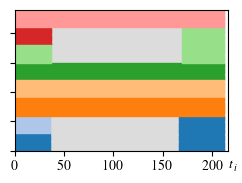

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
(212, 120)
['label_smoothing', 'smoothed_graph', 'smoothed_louvain']
spectral_geodesic_smoothing
Time to make modeled clustering matrices: 0.2455148696899414
M1 symmetric: True
MT symmetric: True
init time: 0.009097099304199219
Starting iterations
Iteration 0
It

  0% (0 of 212) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


starting algorithm timer...
starting label_smoothing


  1% (3 of 212) |                        | Elapsed Time: 0:00:00 ETA:   0:00:03
  4% (9 of 212) |#                       | Elapsed Time: 0:00:00 ETA:   0:00:02
  6% (14 of 212) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:02
  8% (19 of 212) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:02
 11% (25 of 212) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:02
 14% (30 of 212) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:02
 16% (35 of 212) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:02
 17% (38 of 212) |####                   | Elapsed Time: 0:00:00 ETA:   0:00:02
 20% (43 of 212) |####                   | Elapsed Time: 0:00:00 ETA:   0:00:02
 23% (49 of 212) |#####                  | Elapsed Time: 0:00:00 ETA:   0:00:02
 25% (54 of 212) |#####                  | Elapsed Time: 0:00:00 ETA:   0:00:02
 28% (60 of 212) |######                 | Elapsed Time: 0:00:00 ETA:   0:00:02
 30% (65 of 212) |#######               

Time elapsed: 5.63 seconds


  0% (0 of 212) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


starting algorithm timer...
starting smoothed_graph


  1% (3 of 212) |                        | Elapsed Time: 0:00:00 ETA:   0:00:07
  2% (6 of 212) |                        | Elapsed Time: 0:00:00 ETA:   0:00:06
  4% (9 of 212) |#                       | Elapsed Time: 0:00:00 ETA:   0:00:05
  5% (11 of 212) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:05
  6% (14 of 212) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:05
  7% (16 of 212) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:06
  8% (19 of 212) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:05
 10% (22 of 212) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:05
 11% (25 of 212) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:05
 12% (27 of 212) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:05
 14% (30 of 212) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:05
 15% (33 of 212) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:05
 16% (35 of 212) |###                   

Time elapsed: 6.73 seconds


  0% (0 of 212) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


starting algorithm timer...
starting smoothed_louvain


  1% (3 of 212) |                        | Elapsed Time: 0:00:00 ETA:   0:00:03
  4% (9 of 212) |#                       | Elapsed Time: 0:00:00 ETA:   0:00:02
  8% (17 of 212) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:02
 10% (22 of 212) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:02
 14% (30 of 212) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:02
 15% (33 of 212) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:02
 17% (38 of 212) |####                   | Elapsed Time: 0:00:00 ETA:   0:00:02
 20% (43 of 212) |####                   | Elapsed Time: 0:00:00 ETA:   0:00:02
 23% (49 of 212) |#####                  | Elapsed Time: 0:00:00 ETA:   0:00:02
 25% (54 of 212) |#####                  | Elapsed Time: 0:00:00 ETA:   0:00:01
 28% (60 of 212) |######                 | Elapsed Time: 0:00:00 ETA:   0:00:01
 30% (65 of 212) |#######                | Elapsed Time: 0:00:00 ETA:   0:00:01
 33% (70 of 212) |#######               

Time elapsed: 2.56 seconds
Plotting metric: ami
For algorithm: Geodesic Spectral Clustering
Computing metric for simulation 1...
metric: AMI
long data
For algorithm: Label Smoothing
Computing metric for simulation 1...
metric: AMI
long data
For algorithm: Smoothed Graph
Computing metric for simulation 1...
metric: AMI
long data
For algorithm: Smoothed Louvain
Computing metric for simulation 1...
metric: AMI
long data


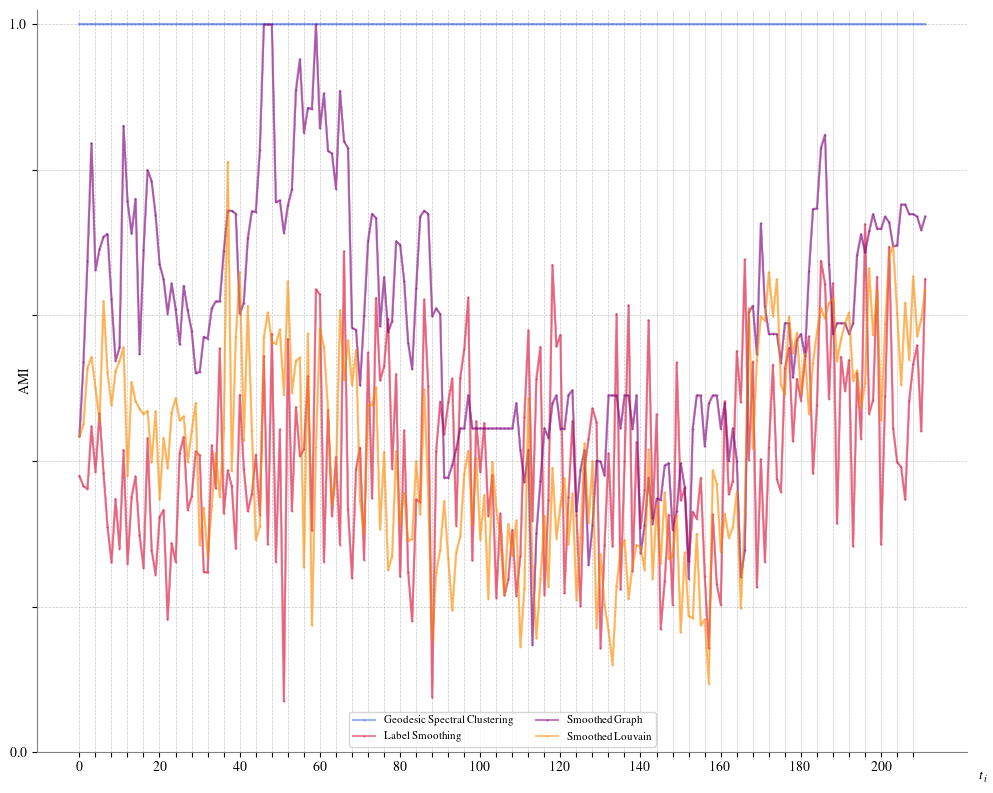

/Users/jacobhume/OneDrive/School/FA2025/SPADA/spectral-dcd/spectraldcd/visualization/metric_plotting.py:510: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figlegend.show()


<Figure size 183.333x110 with 0 Axes>

In [11]:
# choose algs to benchmark against
tn_algs = (tn.DCD.label_smoothing,  tn.DCD.smoothed_graph, tn.DCD.smoothed_louvain)
tn_alg_names = ["label_smoothing", "smoothed_graph", "smoothed_louvain"]

adjacency_matrices, labels_true, comms_snapshots = eight_comms_merge_into_six(show=True)
benchmark(adjacency_matrices, labels_true, 8, tn_algs, tn_alg_names)

